In [1]:
import warnings
warnings.filterwarnings('ignore')

import pathlib
import pickle
import random
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from scipy import ndimage

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features']
        # 1D numpy.ndarray type, for train = (34799,)
        target = d['labels']
        # 2D numpy.ndarray type, for train = (34799, 2)
        sizes = d['sizes']
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']

    return input_data, target, sizes, coords

In [4]:
train_path = "drive/My Drive/Colab Notebooks/lab2_dataset/train.pickle"
test_path = "drive/My Drive/Colab Notebooks/lab2_dataset/test.pickle"
valid_path = "drive/My Drive/Colab Notebooks/lab2_dataset/valid.pickle"
label_names_path = "drive/My Drive/Colab Notebooks/lab2_dataset/label_names.csv"
model_path = lambda name: f"drive/My Drive/Colab Notebooks/lab2_dataset/{name}.model"

In [5]:
X_train, y_train, *_ = load_data(train_path)
X_test, y_test, *_ = load_data(test_path)
X_valid, y_valid, *_ = load_data(valid_path)

In [6]:
label_names = pd.read_csv(label_names_path)

In [7]:
print("Training examples : ", len(X_train))
print("Validation examples : ", len(X_valid))
print("Testing examples : ", len(X_test))
print("Image data shape : ", X_train.shape)
print("Total classes : ", len(set(y_test)))

Training examples :  34799
Validation examples :  4410
Testing examples :  12630
Image data shape :  (34799, 32, 32, 3)
Total classes :  43


In [8]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)

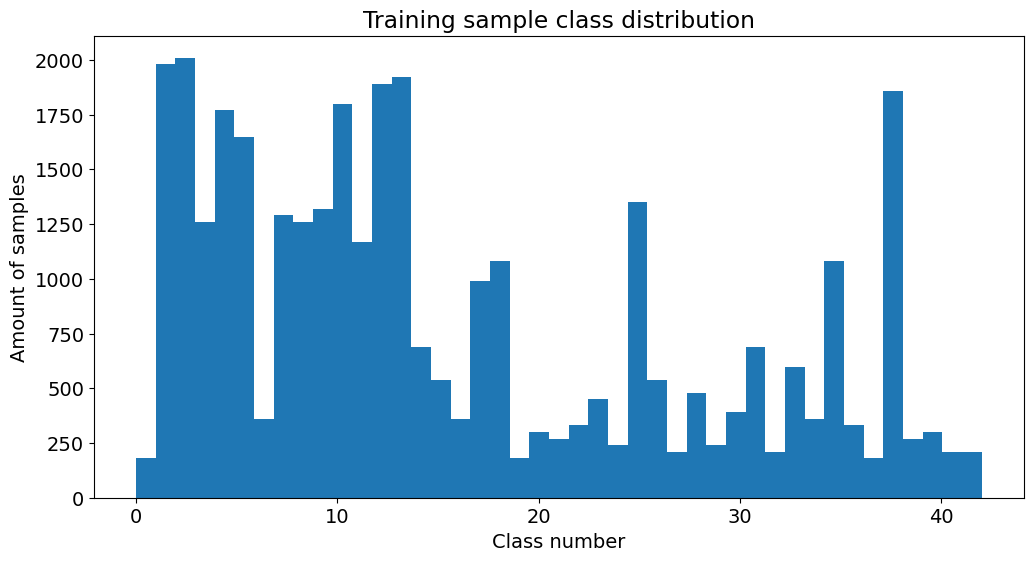

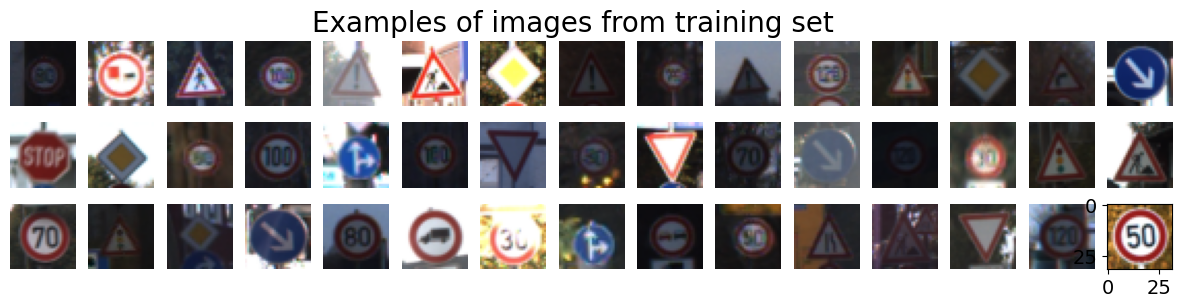

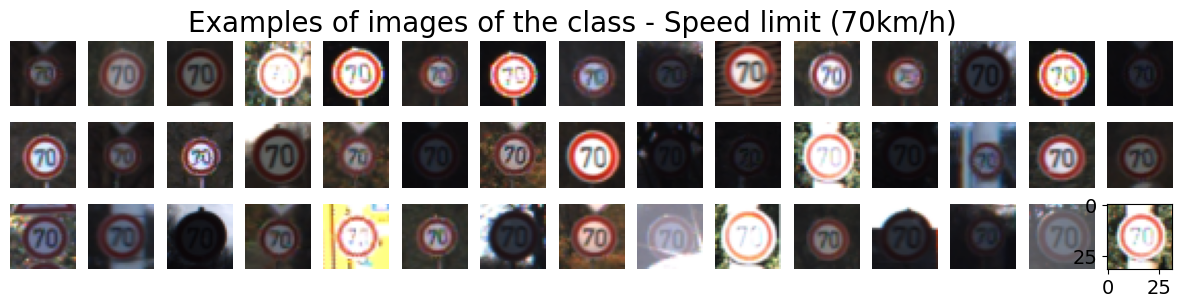

In [9]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

draw_images_examples(X_train, 15, 3, 'Examples of images from training set')

example_class = y_train[random.randint(0, len(y_train))]

X_train_one_label = X_train[np.where(y_train==example_class)]
draw_images_examples(X_train_one_label, 15, 3, f'Examples of images of the class - {label_names["SignName"][example_class]}')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [11]:
class TrafficSignDataset(Dataset):
    def __init__(self, path, transform=None):
        self.X, self.y, *_ = load_data(path)
        self.count = len(self.y)
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform is not None:
            X = self.transform(X)
        return X, self.y[index]

    def __len__(self):
        return self.count

In [12]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [13]:
class LeNet(nn.Module):
    def __init__(self, gray=False):
        super(LeNet, self).__init__()
        input_channels = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def loss(model, loss_func, X, y, optimizer=None):
    loss = loss_func(model(X), y)
    if optimizer is not None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss.item(), len(X)

In [15]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss.item(), torch.sum(correct).item(), len(X)

In [16]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf
    curr_epoch = 0
    train_loss = np.Inf
    valid_loss = np.Inf
    valid_accuracy = np.Inf

    for epoch in tqdm(range(epochs)):
        curr_epoch = epoch + 1
        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                #print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"\n\nTerminated Training for Early Stopping at " \
                          f"Epoch: {curr_epoch:3}, loss: {train_loss:.5f}, " \
                          f"valid loss: {valid_loss:.5f}, valid accruacy: " \
                          f"{valid_accuracy:.3f}%")
                    return graphic_losses

    print(f"\nEpoch: {curr_epoch:3}, loss: {train_loss:.5f}, "\
          f"valid loss: {valid_loss:.5f}, valid accruacy: "\
          f"{valid_accuracy:.3f}%")
    return graphic_losses

In [17]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [18]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [19]:
def train(model, criterion, optimizer, n_epochs, transforms, saving_model_path=None, custom_train_path=None):
    if custom_train_path is not None:
        train_dataset = TrafficSignDataset(custom_train_path, transform=transforms)
    else:
        train_dataset = TrafficSignDataset(train_path, transform=transforms)
    valid_dataset = TrafficSignDataset(valid_path, transform=transforms)
    test_dataset = TrafficSignDataset(test_path, transform=transforms)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

    print('Fitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time:.3f} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print(f'Saving model to: {saving_model_path}')
        torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)

In [20]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20

Fitting nn model


 75%|███████▌  | 15/20 [00:57<00:19,  3.81s/it]



Terminated Training for Early Stopping at Epoch:  16, loss: 0.03627, valid loss: 0.67986, valid accruacy: 88.662%
Fit time: 57.214 s


Test loss: 0.87507	Test accruacy: 85.321%
Saving model to: base_model


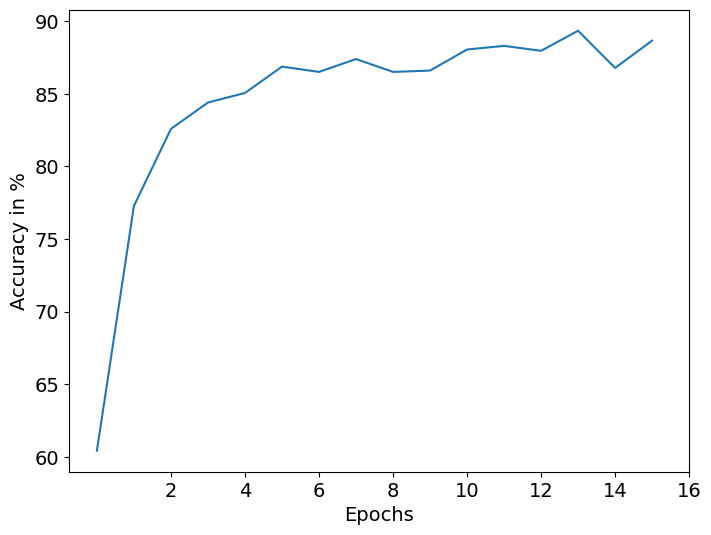

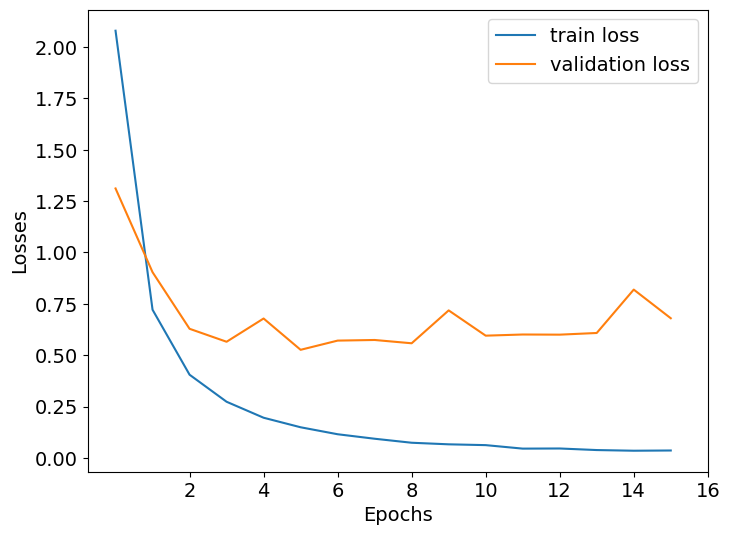

In [21]:
train(model, criterion, optimizer, n_epochs, transforms.ToTensor(), 'base_model')

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 43):
        super(ResNet, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes

        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [24]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

Fitting nn model


100%|██████████| 20/20 [1:31:39<00:00, 274.98s/it]



Epoch:  20, loss: 0.01364, valid loss: 0.13116, valid accruacy: 97.710%
Fit time: 5499.571 s
Test loss: 0.12312	Test accruacy: 97.213%
Saving model to: res_net


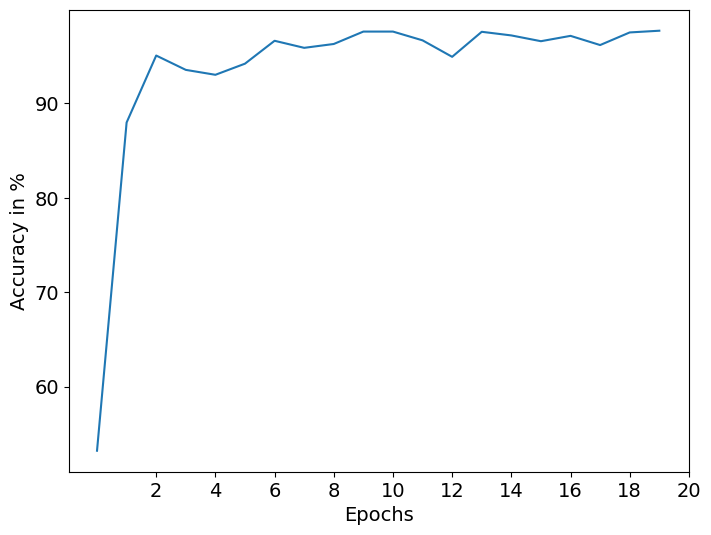

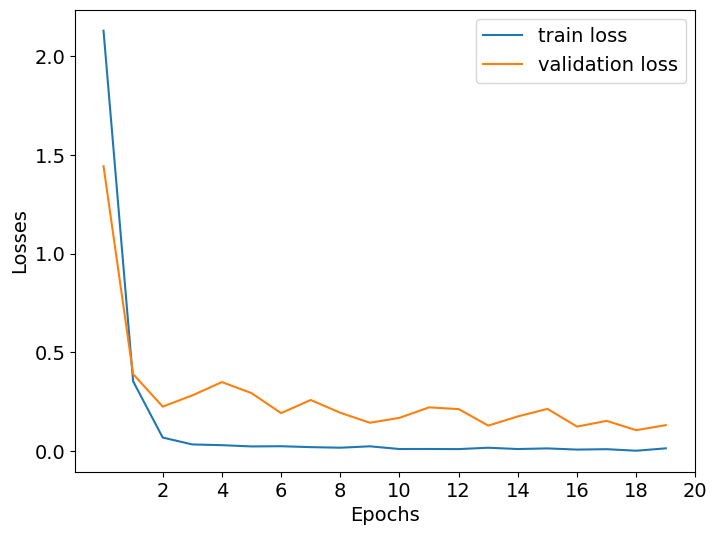

In [25]:
train(model, criterion, optimizer, n_epochs, transform, 'res_net')